# Evaluating Machine Learning Models

## Supervised learning

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

In [2]:
ptype_smaller = "/glade/scratch/cbecker/ptype_data_workshop.parquet"

In [3]:
f = pd.read_parquet(ptype_smaller)

In [4]:
f.head()

,TEMP_C_0_m,TEMP_C_250_m,TEMP_C_500_m,TEMP_C_750_m,TEMP_C_1000_m,TEMP_C_1250_m,TEMP_C_1500_m,TEMP_C_1750_m,TEMP_C_2000_m,TEMP_C_2250_m,...,PRES_Pa_9250_m,PRES_Pa_9500_m,PRES_Pa_9750_m,PRES_Pa_10000_m,datetime,ptype,CRAIN,CSNOW,CICEP,CFRZR
4,23.792603,24.434848,23.063671,21.466505,19.858570,18.084120,16.379408,14.745566,13.005380,11.366903,...,314.614761,303.631238,293.126993,282.859459,2018-06-24 01:00:00,rain,0.0,0.0,0.0,0.0
244,24.692841,23.404617,21.572288,19.692281,17.704285,15.528570,13.295979,10.976451,8.600362,6.223896,...,288.719986,277.785534,267.405164,257.214195,2018-05-05 23:00:00,rain,1.0,0.0,0.0,0.0
296,19.856262,18.168380,17.191451,16.277123,15.205750,13.871668,12.423215,11.066329,9.777620,8.329489,...,302.451326,291.821686,281.351013,271.152749,2022-05-26 13:00:00,rain,1.0,0.0,0.0,0.0
1462,8.415131,7.124995,7.089885,6.754340,5.900241,5.009302,4.145222,2.992119,1.637725,0.449685,...,285.725813,274.890936,264.798894,254.706851,2022-02-22 20:00:00,rain,1.0,0.0,0.0,0.0
159,12.743683,12.987474,11.782320,9.807290,7.905832,6.376726,4.975285,3.382833,1.605579,-0.141400,...,281.754588,271.152847,261.051023,250.949200,2018-01-23 03:00:00,rain,1.0,0.0,0.0,0.0


In [5]:
input_features = []
for feature in ["TEMP_C", "T_DEWPOINT_C", "UGRD_m/s", "VGRD_m/s"]:
    input_features += [f"{feature}_{k}_m" for k in range(0, 10200, 250)]

In [6]:
num_classes = 4
output_feature = "ptype"

In [7]:
total_length = len(f)
train_length = int(0.8 * total_length)
valid_length = int(0.1 * total_length)

train_data = f[:train_length].copy()
valid_data = f[train_length:train_length + valid_length].copy()
test_data = f[train_length + valid_length:].copy()

Preprocessing the inputs

In [8]:
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(train_data[input_features])
x_valid = scaler_x.transform(valid_data[input_features])
x_test = scaler_x.transform(test_data[input_features])

Preprocessing the outputs

In [9]:
from sklearn.preprocessing import LabelEncoder

# Create a OneHotEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the labels for y_train
y_train = label_encoder.fit_transform(train_data[output_feature].values)
y_valid = label_encoder.transform(valid_data[output_feature].values)
y_test = label_encoder.transform(test_data[output_feature].values)

In [10]:
label_encoder.inverse_transform([0, 1, 2, 3])

array(['fzra', 'icep', 'rain', 'snow'], dtype=object)

In [11]:
label_encoder.transform(label_encoder.inverse_transform([0, 1, 2, 3]))

array([0, 1, 2, 3])

In [12]:
labels = label_encoder.inverse_transform([0, 1, 2, 3])

In [13]:
from sklearn.preprocessing import OneHotEncoder

# Create a OneHotEncoder instance
encoder = OneHotEncoder()

# Fit and transform the labels for y_train
y_train_hot = encoder.fit_transform(train_data[output_feature].values.reshape(-1, 1))
y_valid_hot = encoder.transform(valid_data[output_feature].values.reshape(-1, 1))
y_test_hot = encoder.transform(test_data[output_feature].values.reshape(-1, 1))

### Train a classifier model on the ptype dataset to predict label with probabilities

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
model = RandomForestClassifier(n_estimators=10, random_state=42, verbose=1)
model.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.7min finished


RandomForestClassifier(n_estimators=10, random_state=42, verbose=1)

In [16]:
# Make predictions on the test data
test_data["true_label"] = y_test
test_data["pred_label"] = model.predict(x_test)
pred_probs = model.predict_proba(x_test)
test_data[[f"pred_prob{k+1}" for k in range(num_classes)]] = pred_probs
test_data["pred_prob"] = np.max(pred_probs, axis = 1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


### The confusion matrix

A confusion matrix is a visual representation of the performance of a classification model on a set of test data for a K-class (multiclass) problem. It shows how many of the true class labels were predicted correctly (true positives) and how many were predicted as other classes (false positives). It also shows how many instances of each class were predicted as another class (false negatives) and how many were correctly classified as a different class (true negatives). In other words, it provides a detailed breakdown of the model's predictions and errors.

The confusion matrix is useful because it allows you to assess the model's performance, understand where it is making errors, and calculate various performance metrics like accuracy, precision, recall, and F1-score. These metrics are essential for evaluating the quality of a classification model and making necessary improvements.

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, model_name, axis=0, title=None, cmap=plt.cm.Blues, filename=None):
    """
    Function to plot a confusion matrix.
    """
    if not title:
        if axis == 0:
            title = 'Confusion Matrix (x-axis)'
        elif axis == 1:
            title = 'Confusion Matrix (y-axis)'
        else:
            title = 'Confusion Matrix (unnormalized)'

    cm = confusion_matrix(y_true, y_pred)

    if axis == 0:
        cm = cm.astype('float') / cm.sum(axis=0, keepdims=True)
    elif axis == 1:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, shrink=0.80)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]))
    ax.set_xticklabels(classes, fontsize=10)
    ax.set_yticklabels(classes, fontsize=10)
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('True label', fontsize=10)
    ax.set_xlabel('Predicted label', fontsize=10)

    fmt = '.2f' if axis >= 0 else 'd'
    thresh = cm.max() / 2.

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=10)


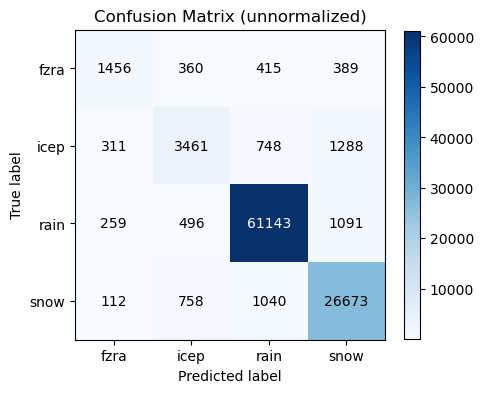

In [18]:
plot_confusion_matrix(test_data["true_label"], 
                      test_data["pred_label"], 
                      labels, 
                      "MLP", 
                      axis=-1)

plt.show()

### Bulk metrics

When evaluating the performance of a classification model, it is essential to compute distinct metrics derived from the confusion matrix for each class. This approach holds considerable significance for several reasons.

- **Tailored Assessment:** Computing different metrics based on the confusion matrix for each class allows for a tailored evaluation of the model's performance in the context of each class. This is essential because not all classification tasks are equal; different classes may have varying degrees of importance or cost associated with them. For instance, in a medical diagnosis task, the consequences of misclassifying a life-threatening condition differ from those of a less critical ailment.
  
- **Handling Class Imbalance:** Class imbalance is a common challenge in machine learning, where certain classes may have significantly fewer samples than others. When evaluating the model's performance, considering class-specific metrics is crucial to avoid biased assessments. Imbalance often leads to models favoring majority classes while neglecting minority ones. By calculating metrics for individual classes, we can assess how well the model performs for both minority and majority classes, ensuring that the evaluation is balanced.

- **Understanding Error Patterns:** Examining class-specific metrics helps distinguish between different error patterns exhibited by the model for each class. It allows us to identify where the model excels and where it struggles. 

- **Robustness Evaluation:** Robustness is crucial, particularly in applications where the consequences of misclassification can vary widely. By assessing class-specific metrics, we can evaluate how resilient the model is to errors in specific categories.

In [19]:
def compute_classification_metrics_multiclass(y_true, y_pred, labels=None):
    """
    Compute various classification metrics for multi-class classification.
    
    Parameters:
        y_true (array-like): True class labels. 
        y_pred (array-like): Predicted class labels.
        labels (array-like): List of class labels (optional).
        
    Returns:
        dict: A dictionary containing various classification metrics.
    """
    
    # Define the classes of interest
    classes_of_interest = [0, 1, 2, 3]

    # Initialize a dictionary to store metrics for each class
    metrics = {}

    for class_of_interest in classes_of_interest:
        # Get the true labels for the class of interest (positive) and the rest (negative)
        y_true_positive = (y_true == class_of_interest).astype(int)
        y_true_negative = 1 - y_true_positive

        # Get the predicted labels for the class of interest (positive) and the rest (negative)
        y_pred_positive = (y_pred == class_of_interest).astype(int)
        y_pred_negative = 1 - y_pred_positive

        # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
        tp = np.sum(y_true_positive * y_pred_positive)
        fp = np.sum(y_true_negative * y_pred_positive)
        tn = np.sum(y_true_negative * y_pred_negative)
        fn = np.sum(y_true_positive * y_pred_negative)

        # Calculate various binary classification metrics
        sensitivity = tp / (tp + fn)  # Sensitivity (Recall)
        specificity = tn / (tn + fp)  # Specificity
        precision = tp / (tp + fp)    # Precision
        npv = tn / (tn + fn)          # Negative Predictive Value (NPV)
        fnr = fn / (fn + tp)          # False Negative Rate (FNR)
        fpr = fp / (fp + tn)          # False Positive Rate (FPR)
        fdr = fp / (fp + tp)          # False Discovery Rate (FDR)
        forr = fn / (fn + tn)         # False Omission Rate (FOR)
        lr_plus = sensitivity / fpr   # Positive Likelihood Ratio (LR+)
        lr_minus = fnr / specificity  # Negative Likelihood Ratio (LR-)
        pt = np.sqrt(fpr) / (np.sqrt(sensitivity) + np.sqrt(fpr))  # Prevalence Threshold (PT)
        ts = tp / (tp + fn + fp)     # Threat Score (TS)
        
        # Calculate F1 Score (Harmonic mean of precision and recall)
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

        # Additional metrics
        prevalence = (tp + fn) / (tp + tn + fp + fn)  # Prevalence
        accuracy = (tp + tn) / (tp + tn + fp + fn)    # Accuracy
        balanced_accuracy = (sensitivity + specificity) / 2  # Balanced Accuracy
        mcc = (tp * tn - fp * fn) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))  # Matthews Correlation Coefficient (MCC)
        informedness = sensitivity + specificity - 1  # Informedness
        markedness = precision + npv - 1  # Markedness
        dor = lr_plus / lr_minus  # Diagnostic Odds Ratio (DOR)
        
        # Combine keys for metrics that share multiple acronym names
        # Add the missing metrics and acronyms
        metrics[labels[class_of_interest]] = {
            "TPR,Sensitivity,Recall": sensitivity,
            "Specificity": specificity,
            "Precision": precision,
            "NPV": npv,
            "FNR": fnr,
            "FPR,FAR": fpr,
            "FDR": fdr,
            "FOR": forr,
            "LR+": lr_plus,
            "LR-": lr_minus,
            "PT": pt,
            "TS,CSI": ts,
            "F1": f1,
            "Prevalence": prevalence,
            "Accuracy": accuracy,
            "Balanced Accuracy": balanced_accuracy,
            "MCC": mcc,
            "Informedness": informedness,
            "Markedness": markedness,
            "DOR": dor
        }
        
    return metrics

In [20]:
metrics = compute_classification_metrics_multiclass(
    test_data["true_label"], 
    test_data["pred_label"],
    labels
)

In [21]:
# Extract class names and metrics names
class_names = list(metrics.keys())
metric_names = list(next(iter(metrics.values())).keys())

# Create a separator line
separator = '+'.join(['-' * 25 for _ in class_names]) + "+" + '-' * 25

# Print header row with class names
header_row = 'Metric\t\t\t\t\t' + ''.join(f'{class_name:<25}' for class_name in class_names)
print(header_row)
print(separator)

# Print data rows
for metric_name in metric_names:
    row_data = f'{metric_name:<25}\t\t' + ''.join(f'{metrics[class_name][metric_name]:<25.3f}' for class_name in class_names)
    print(row_data)

print(separator)

Metric					fzra                     icep                     rain                     snow                     
-------------------------+-------------------------+-------------------------+-------------------------+-------------------------
TPR,Sensitivity,Recall   		0.556                    0.596                    0.971                    0.933                    
Specificity              		0.993                    0.983                    0.940                    0.961                    
Precision                		0.681                    0.682                    0.965                    0.906                    
NPV                      		0.988                    0.975                    0.950                    0.973                    
FNR                      		0.444                    0.404                    0.029                    0.067                    
FPR,FAR                  		0.007                    0.017                    0.060                    0.039           

### Brier Skill Score Metric

The **Brier Skill Score (BSS)** is a measure of how well a forecasted probability distribution matches the observed outcomes. The Brier Skill Score compares the performance of a forecast to that of a reference forecast (often a climatological forecast) and is used to determine whether a forecasting model adds value compared to a simple reference forecast.

The BSS is calculated as the difference between two components:

1. **Brier Score (BS)**: The Brier Score is a measure of the accuracy of the forecast. It quantifies the mean squared difference between the forecasted probabilities and the actual binary outcomes (0 for incorrect, 1 for correct). A lower Brier Score indicates better forecast accuracy.

   Brier Score = \(\frac{1}{N} \sum_{i=1}^N (f_i - o_i)^2\)

   Where \(N\) is the number of forecasts, \(f_i\) is the forecasted probability for event occurrence, and \(o_i\) is the actual outcome (0 or 1).

2. **Reference Brier Score (BSref)**: The Reference Brier Score represents the expected accuracy of a reference forecast. It is calculated in the same way as the Brier Score, using the reference forecast probabilities.

   Reference Brier Score = \(\frac{1}{N} \sum_{i=1}^N (r_i - o_i)^2\)

   Where \(r_i\) is the probability from the reference forecast.

The Brier Skill Score is defined as:

BSS = \(\frac{{BSref - BS}}{{BSref}}\)

A BSS of 1 indicates a perfect forecast, where the forecast model is significantly better than the reference forecast. A BSS of 0 suggests that the forecast model provides no improvement over the reference forecast, and a negative BSS indicates that the forecast is worse than the reference.

In summary, the Brier Skill Score quantifies the improvement in forecast accuracy provided by a forecasting model compared to a reference forecast. It is a valuable tool for evaluating forecast performance, particularly in applications involving categorical event predictions.

In [22]:
def brier_multi(targets, probs, num_classes=4, skill_score=True, row_wise=False):
    # Create one-hots of the target to deal with multi-class problems
    one_hot = np.zeros((targets.shape[0], num_classes))
    one_hot[np.arange(targets.shape[0]), targets] = 1
    # Compute MSE with one-hots and probabilities
    squared_errors = (probs - one_hot) ** 2
    
    if row_wise:
        # Calculate Brier Score row-wise
        res = np.mean(squared_errors, axis=1)
    else:
        # Calculate the bulk Brier Score
        res = np.mean(squared_errors)

    if skill_score:
        if row_wise:
            # Calculate row-wise Brier Skill Score
            tot = np.mean((one_hot - np.mean(one_hot, axis=0)) ** 2, axis=1)
        else:
            # Calculate the bulk Brier Skill Score
            tot = np.mean((one_hot - np.mean(one_hot, axis=0)) ** 2)
        return 1 - res / np.maximum(tot, 1.0e-7)
    else:
        return res

In [23]:
print(
    brier_multi(test_data["true_label"], pred_probs, skill_score = False, row_wise = False),
    brier_multi(test_data["true_label"], pred_probs, skill_score = True, row_wise = False)
)

0.02856595 0.7791918838035659


In [24]:
test_data["brier_score"] = brier_multi(test_data["true_label"], pred_probs, skill_score = False, row_wise = True)
test_data["brier_skill_score"] = brier_multi(test_data["true_label"], pred_probs, skill_score = True, row_wise = True)

# ROC (Receiver Operating Characteristic) and AUC (Area Under the Curve)

In machine learning, especially in multi-class classification tasks with four classes, the ROC curve and AUC are essential tools for evaluating the performance of a model. Here's what they are and why they matter:

## ROC Curve
The ROC curve is a graphical representation of a model's ability to distinguish between one class and the combination of the other three classes at different thresholds. It is especially useful when you want to understand how well a model separates one class from the rest and how the true positive rate (sensitivity) and false positive rate (1-specificity) change with varying classification thresholds.

- **X-Axis**: False Positive Rate (FPR) or (1-specificity)
  - It represents the ratio of false positive predictions for the one class to the total actual negatives (the three other classes).
  - Formula: `FPR = FP / (FP + TN of the three other classes)`

- **Y-Axis**: True Positive Rate (TPR) or Sensitivity or Recall
  - It represents the ratio of true positive predictions for the one class to the total actual positives (the one class).
  - Formula: `TPR = TP / (TP + FN of the one class)`

Each point on the ROC curve corresponds to a different threshold for classifying the one class. The curve allows you to see how well your model performs across various thresholds for this one-versus-all classification. An ideal model's curve would extend vertically to the top-left corner, indicating high TPR and low FPR at all thresholds.

## AUC (Area Under the Curve)
The AUC is a scalar value that quantifies the overall performance of a classification model for this one-versus-all problem. It represents the area under the ROC curve for this particular class. A perfect model will have an AUC of 1, indicating it can perfectly distinguish the one class from the others. A random model will have an AUC of 0.5, similar to guessing. The AUC ranges between 0 and 1, and a higher AUC suggests better model performance for this class.

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_auc(y_true, y_probabilities, classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_probabilities[:, i])
        roc_auc[i] = roc_auc_score(y_true[:, i], y_probabilities[:, i])

    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC Curve ({classes[i]}, AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', color='gray', lw=2, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Each Class')
    plt.legend(loc='best')
    plt.show()

/glade/derecho/scratch/schreck/tmp/ipykernel_47638/440677831.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray', lw=2, label='Random')


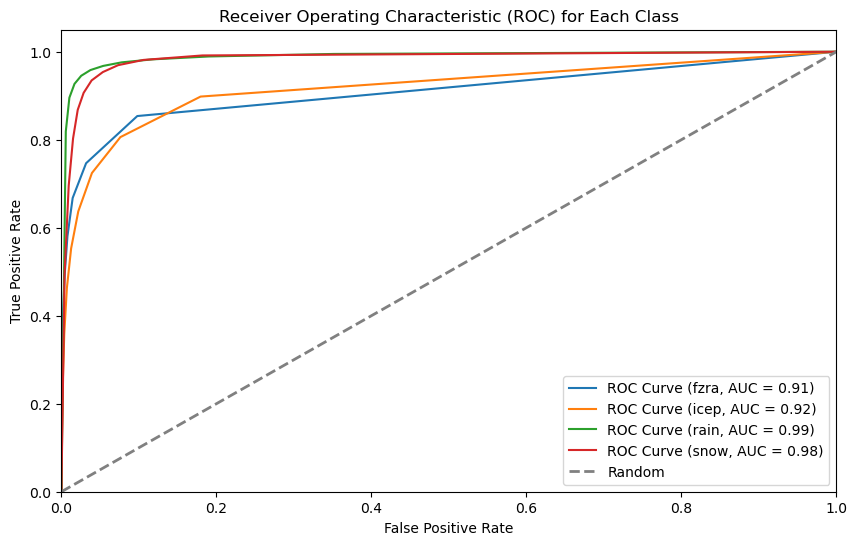

In [26]:
plot_roc_auc(y_test_hot.toarray(), 
             pred_probs, 
             label_encoder.inverse_transform([0,1,2,3]))

## Attributes (reliability) Diagram for a 4-Class Problem

A reliability diagram, often referred to as a calibration curve, serves as a visual tool for evaluating the precision of predicted probabilities in the context of a multi-class classification model. This diagram compares the expected class frequencies with the predicted probabilities for each class. Its primary objective is to determine whether the model's predicted probabilities closely match the actual results, signifying a well-calibrated model.

### Why is it Important?
The reliability diagram helps you answer essential questions about your model's performance:

- **Calibration**: Does the model's predicted probability reflect the true likelihood of an event occurring? In a 4-class problem, this is particularly vital, as it ensures that the model assigns meaningful probabilities to all classes.

- **Discrimination**: Is the model capable of distinguishing between different classes with high accuracy? The reliability diagram offers insights into the model's ability to discriminate between multiple classes.

- **Misclassification**: Are there classes for which the model consistently underestimates or overestimates the likelihood of occurrence? The reliability diagram reveals misclassification patterns.

- **Model Confidence**: How confident is the model in its predictions for each class? The curves' deviation from the diagonal line indicates the model's confidence level in its predicted probabilities.

In [27]:
from collections import defaultdict, OrderedDict
import matplotlib


def sort_arr(true_labels, pred_probs, confidences, n_bins=10, data_min = None, data_max = None, geom = True):
    
    # Compute the minimum and maximum values
    if data_min is None:
        data_min = np.min(confidences)
    if data_max is None:
        data_max = np.max(confidences)

    # Compute the range and standard deviation
    data_range = data_max - data_min
    data_std = np.std(confidences)

    # Use np.geomspace if the range of values is large compared to the standard deviation
    if data_range > 10 * data_std and geom:
        if data_min  == 0.0:
            data_min = 1e-7
        bins = np.geomspace(data_min, data_max, n_bins + 1)

    # Use np.linspace if the range of values is small compared to the standard deviation
    else:
        bins = np.linspace(data_min, data_max, n_bins + 1)

    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    pred_labels = np.argmax(pred_probs, axis=1)
    results = defaultdict(list)
    for i in range(n_bins):
        condition = np.logical_and(confidences >= bins[i], confidences < bins[i + 1])
        if condition.sum() > 0:
            bs = brier_multi(true_labels[condition], pred_probs[condition], skill_score = False)
            results["bss"].append(bs)
            results["eb"].append(1.0 / np.sqrt(condition.sum()))
            results["acc"].append(
                (true_labels[condition] == pred_labels[condition]).mean()
            )
            results["count"].append(condition.sum())
            results["bin"].append(bin_centers[i])
            results["conf"].append(np.mean(confidences[condition]))
            
            
        else:
            results["count"].append(0)
            results["bin"].append(bin_centers[i])
            results["acc"].append(0.0)
            results["eb"].append(0.0)
            results["bss"].append(0.0)
            results["conf"].append(0.0)

    return results["bin"], results


def classifier_attribution(
    true_labels,
    pred_probs,
    num_bins=9,
    legend_cols=["Rain", "Snow", "Sleet", "Frz Rain"],
):
    
    fig, axs = plt.subplots(1, 4, figsize=(10, 3), sharey="row", sharex="col")
    confidences = np.max(pred_probs, axis=1)

    for true_label in sorted(set(list(true_labels))):

        c = true_labels == true_label
        bin_centers, results = sort_arr(
            true_labels[c], pred_probs[c], confidences[c], n_bins = num_bins,
            data_min = 0, data_max = 1, geom = False
        )
        
        normalized_counts = (results["count"] - np.min(results["count"])) / (np.max(results["count"]) - np.min(results["count"]))
        colormap = matplotlib.colormaps.get_cmap('Reds')
        sc = axs[true_label].scatter(
            bin_centers, results["acc"], c=normalized_counts, 
            cmap = colormap, zorder = 5, marker='s', s = 100, edgecolor = "k"
        )
        sc.set_clip_on(False)
        bin_centers = np.linspace(0, 1, num_bins)
        ave_true = np.mean(true_labels == true_label)
        ave_true_range = np.array([ave_true for x in bin_centers])

        no_skill = [0.5 * x1 + 0.5 * ave_true for x1 in bin_centers]
        axs[true_label].plot(bin_centers, no_skill, "b-")
        axs[true_label].plot(
            np.linspace(0, 1, len(ave_true_range)), ave_true_range, ls=":", color="k"
        )
        axs[true_label].plot(
            ave_true_range, np.linspace(0, 1, len(ave_true_range)), ls=":", color="k"
        )
        axs[true_label].plot(bin_centers, bin_centers, ls=":", color="k")

        # Redefine to there are no gaps in the figure
        bin_centers = np.linspace(0, 1, 10 * num_bins)
        no_skill = [0.5 * x1 + 0.5 * ave_true for x1 in bin_centers]
        fill_cond = np.where(bin_centers <= ave_true)[0]
        axs[true_label].fill_between(
            np.array(bin_centers)[fill_cond],
            0,
            np.array(no_skill)[fill_cond],
            color="lightblue",
        )
        fill_cond = np.where(bin_centers > ave_true)[0]
        axs[true_label].fill_between(
            np.array(bin_centers)[fill_cond],
            1,
            np.array(no_skill)[fill_cond],
            color="lightblue",
        )
        
        axs[true_label].set_xlim([0, 1.01])
        axs[true_label].set_ylim([0, 1.01])
        axs[true_label].set_title(legend_cols[true_label], fontsize = 10)
        axs[true_label].set_xlabel("Predicted Probability")

    axs[0].set_ylabel("Conditional Observed\n Probability")
    
    # Create a single colorbar
    cbaxes = fig.add_axes([0.125, -0.01, 0.8, 0.035])  # left, bottom, width, height]
    cbar = fig.colorbar(sc, cax=cbaxes, orientation="horizontal", pad = 0.2)
    cbar.set_label("Normalized count")

    plt.tight_layout()

/glade/derecho/scratch/schreck/tmp/ipykernel_47638/4213363201.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


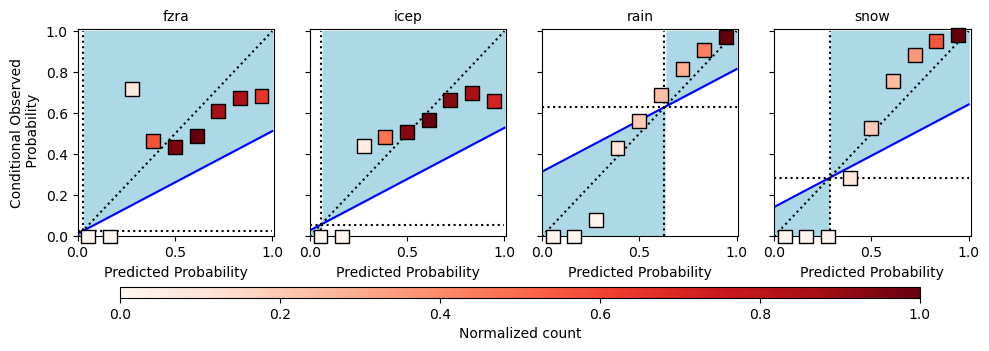

In [28]:
classifier_attribution(
    test_data["true_label"],
    pred_probs, 
    legend_cols = label_encoder.inverse_transform([0,1,2,3])
)

### How to Interpret a Reliability Diagram
In a reliability diagram for a 4-class problem, you typically have four curves, one for each class, each representing the calibration performance for that specific class.

- **X-Axis**: Predicted Probability
  - It ranges from 0 to 1 and represents the probability assigned by the model to a given class.

- **Y-Axis**: Observed Frequency
  - It shows the actual frequency of data points that belong to a specific class.

Ideally, a well-calibrated model will have reliability curves that closely follow the diagonal line (45-degree line) from the bottom-left to the top-right of the plot. This diagonal line represents perfect calibration, where the predicted probabilities match the actual outcomes. In other words, the predicted probability of a class corresponds well with the observed frequency of that class.

## Performance diagram

The performance diagram provides a comprehensive view of a model’s performance across different threshold settings. By examining the trade-off between sensitivity (POD) and specificity (1-FAR), we can gain insights into how well the model can detect true positive instances while minimizing false alarms.

In the code below, we also show the CSI as shaded values in the diagram to provide a visual representation of the model’s performance at different thresholds. The CSI is a key metric in the context of rare event detection, and its value can be optimized by selecting the threshold that maximizes it. By representing the CSI as shaded values, we can easily visualize how the CSI changes as we vary the classification threshold, thereby gaining a better understanding of the model’s ability to effectively detect rare events. This makes the performance diagram a powerful tool for model evaluation and optimization.

In [29]:
from hagelslag.evaluation.MetricPlotter import performance_diagram
from hagelslag.evaluation.ProbabilityMetrics import DistributedROC

/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/hagelslag/evaluation/MetricPlotter.py:132: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/hagelslag/evaluation/MetricPlotter.py:132: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/hagelslag/evaluation/MetricPlotter.py:133: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


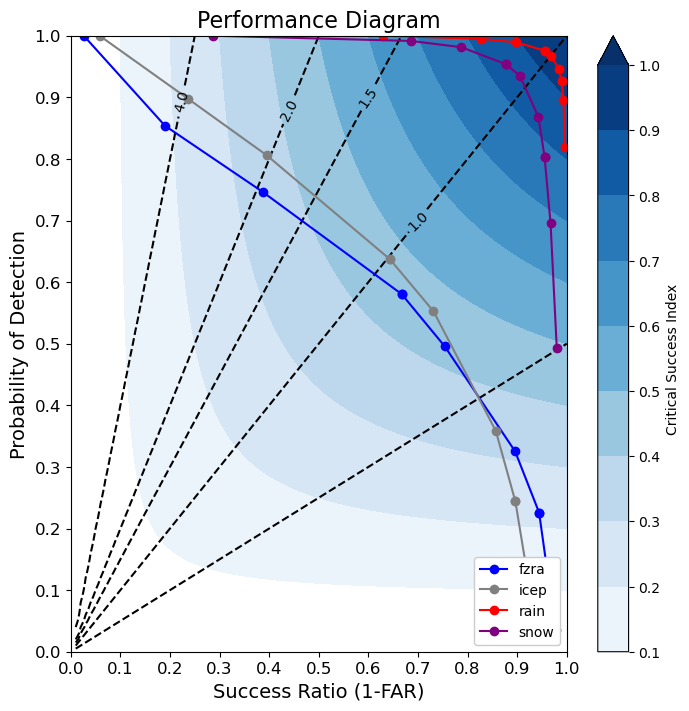

In [30]:
rocs = []
for i in range(4):
    forecasts = pred_probs[:, i]
    obs = np.where(test_data["true_label"] == i, 1, 0)
    roc = DistributedROC()
    roc.update(forecasts, obs)
    rocs.append(roc)
    
try:
    performance_diagram(rocs, label_encoder.inverse_transform([0,1,2,3]), ["blue", "grey", "red", "purple"], ["o"]*4, filename=None)
except AttributeError:
    pass

Some example use-cases where a performance diagram is usful:

1. **Climate Modeling**: In climate modeling, it's crucial to correctly predict extreme weather events (true positives) while minimizing false alarms. For instance, predicting a hurricane when there isn't one can lead to unnecessary evacuations, causing undue stress and economic loss.

2. **Air Quality Monitoring**: In air quality monitoring, models need to accurately predict high pollution events (true positives) while avoiding false alarms. A high rate of false positives could lead to unnecessary public health warnings.

3. **Wildfire Detection**: In wildfire detection, it's important for the model to correctly identify wildfire events (true positives) while avoiding false alarms that could lead to unnecessary deployment of firefighting resources.

4. **Atmospheric Phenomena Detection**: In the detection of atmospheric phenomena like tornadoes or thunderstorms, it's essential for the model to correctly identify these events (true positives) while minimizing false alarms. False alarms could lead to unnecessary panic and resource allocation.

# Automation Determination: How Good is my model, really?

## A: Cumulative Performance Curve

The Cumulative Performance Curve, also known as a Cumulative Curve, is a graphical representation frequently used in data science and machine learning to analyze how the performance of a model evolves with an increasing amount of data. It provides valuable insights into the trade-off between prediction coverage and accuracy.

In [31]:
def calculate_cumulative_coverage(df, prediction_column="predicted_confidence", metric_column="prediction_metric", sort_ascending=False):
    # Make a copy of the DataFrame
    df = df.copy()
    
    # Sort the DataFrame by the prediction column in ascending or descending order
    df.sort_values(prediction_column, ascending=sort_ascending, inplace=True)
    
    # Add a dummy column with a constant value of 1
    df["dummy"] = 1
    
    # Calculate cumulative metric (e.g., accuracy, uncertainty, etc.)
    df[f"cumulative_{metric_column}"] = df[metric_column].cumsum() / df["dummy"].cumsum()
    
    # Calculate cumulative coverage
    df[f"cumulative_{prediction_column}"] = df[prediction_column].cumsum() / df["dummy"].cumsum()
    
    # Calculate coverage rate
    df[f"{prediction_column}_coverage"] = df["dummy"].cumsum() / len(df)
    
    return df

### Key Characteristics:

- **X-Axis**: Represents the dataset size or the fraction of the data being used. It starts with a small fraction and gradually includes more data.

- **Y-Axis**: Represents the performance metric of interest, such as accuracy, precision, or any other relevant measure.

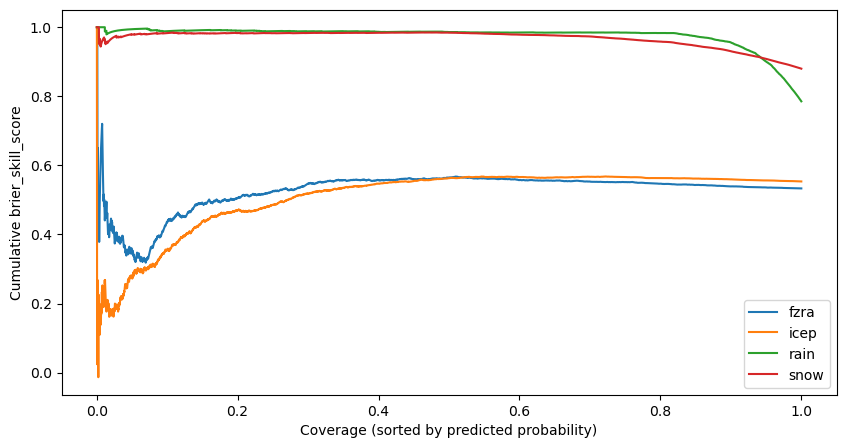

In [32]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
    
metric_column = "brier_skill_score"
pred_column = "pred_prob"
    
for label in range(4):
    cond = (test_data["true_label"] == label)
    _test_data_sorted = calculate_cumulative_coverage(test_data[cond], pred_column, metric_column)
    ax.plot(
        _test_data_sorted[f"{pred_column}_coverage"],
        _test_data_sorted[f"cumulative_{metric_column}"]
    )
    
ax.set_ylabel(f"Cumulative {metric_column}")
ax.set_xlabel("Coverage (sorted by predicted probability)")
plt.legend(label_encoder.inverse_transform([0,1,2,3]))
plt.show()

### Utility:

1. **Balancing Coverage and Accuracy**: The curve illustrates how model performance improves or degrades as more data points are considered. It helps in making informed decisions about the trade-off between covering a broader range of predictions and achieving higher accuracy.

2. **Threshold Selection**: It aids in selecting an appropriate threshold for model predictions. For instance, if you aim for predictions with a certain level of accuracy (e.g., >=95%), the curve allows you to find the threshold point that corresponds to this level.

3. **Model Deployment**: When deploying a model in real-world applications, understanding the cumulative performance curve is crucial. It helps practitioners make decisions about the reliability and scope of their model's predictions.

## B: Discard Fraction

The discard fraction figure is used to understand how model predictions can be filtered based on their predicted confidence scores (or probabilities). This figure is particularly useful when the model's predictions are used to make decisions or take actions, and you want to ensure a certain level of reliability or accuracy.

In [33]:
def classifier_discard_fraction(
    df,
    num_bins=10,
    num_classes=4,
    prob_col="pred_prob",
    legend_cols=["Rain", "Snow", "Sleet", "Frz Rain"],
    plt_title=[],
    colors=["m", "b", "y", "c"], #["#f8d605", "#ce4912", "#042c71", "b", "g"],
    save_location=False,
    prefix=False,
    ascending = False
):
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey="row")
    db = (1.0 / num_classes) * num_bins

    results = defaultdict(list)
    markers = ["o", "s", "p", "^"]
    
    dg = df.sort_values(prob_col, ascending = ascending)

    for class_label in range(num_classes):
        dr = dg[dg["true_label"] == class_label]
        results = defaultdict(list)
        percentage = np.linspace(0, 1, dr.shape[0])
        for percent in np.linspace(5, 100, num_bins):
            c = percentage < percent / 100.0
            if c.sum() == 0:
                continue
            acc = (dr[c]["true_label"] == dr[c]["pred_label"]).mean()
            bss = dr[c]["brier_skill_score"].mean()
            results["acc"].append(acc)
            results["bss"].append(bss)
            results["frac"].append(percent)

        ls = "-"
        marker = markers[class_label]

        ax.plot(
            [100 - x for x in results["frac"]],
            results["bss"],
            color=colors[class_label],
            ls = ls, 
            lw = 2,
            marker=marker,
            markersize=4,
            markevery=1
        )

    ax.set_xlabel("Fraction removed", fontsize = 10)
    ax.set_title(plt_title, fontsize = 10)
    ax.legend(legend_cols, loc="best", fontsize = 10)

    # Create a custom legend with symbols only
    legend_handles = []
    for class_label, legend_col in zip(range(num_classes), legend_cols):
        marker = markers[class_label]
        legend_handles.append(
            plt.Line2D(
                [],
                [],
                marker=marker,
                color="w",
                markerfacecolor=colors[class_label],
                markersize=8,
                label=legend_col,
            )
        )
    ax.legend(handles=legend_handles, loc="best", fontsize = 10)
    ax.set_ylabel("Brier Skill Score", fontsize = 10)

    xarr = [100 - x for x in results["frac"]]
    ax.plot(xarr, [0 for xx in xarr], c = "k", ls = ":")
    plt.tight_layout()

Discard fraction diagram:

1. **Y-Axis (Coverage Rate):** The y-axis represents the coverage rate, which is essentially the fraction of the dataset (or samples) used to make predictions. It starts from 0% at the bottom and goes up to 100% at the top. As you move up on the y-axis, you are considering an increasing proportion of the dataset.

2. **X-Axis (Prediction Metric):** The x-axis represents a chosen prediction metric, which can vary based on your use case. It could be accuracy, precision, recall, or any other metric that reflects the performance of your model. The choice of this metric depends on what you consider a reliable prediction for your application.

3. **Line or Curve:** The figure will display a line or curve that indicates how the chosen prediction metric varies as you increase the coverage rate. The curve shows how the model's performance (as measured by the chosen metric) changes as you make predictions on a larger portion of the dataset.

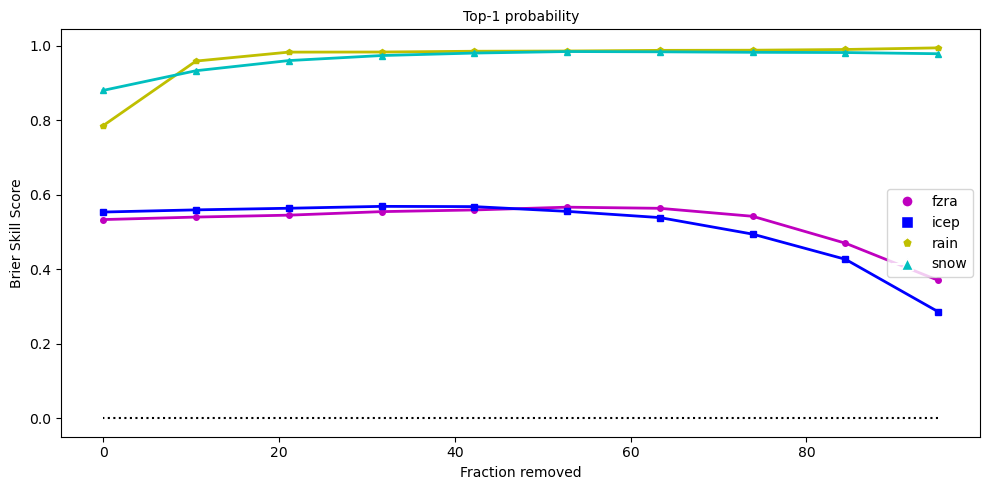

In [34]:
classifier_discard_fraction(
    test_data,
    #save_location=save_location,
    plt_title="Top-1 probability",
    prob_col="pred_prob",
    prefix=None, 
    num_bins = 10,
    legend_cols = label_encoder.inverse_transform([0,1,2,3])
) 

Using a model in production:

- **Threshold Selection:** The figure helps you choose an appropriate threshold for the prediction metric to meet your desired level of performance. For instance, if you want to ensure that the accuracy of your predictions is above a certain threshold (e.g., 95%), you can look at the coverage rate on the y-axis where the curve crosses that threshold on the x-axis. This coverage rate represents the portion of the dataset that meets your reliability criteria.

- **Balancing Act:** Using the discard fraction figure allows you to strike a balance between reliability and coverage. You can decide what level of performance (metric) is acceptable for your use case, and the figure shows you how much of your dataset you need to use to achieve that level.

- **Real-world Decision Making:** In a real-world setting, it helps you decide when to use model predictions with high confidence and when to be cautious. You might use predictions with high confidence for critical decisions and discard or flag predictions with low confidence for further review.

- **Model Monitoring:** Over time, you can use the discard fraction figure to monitor how the model's performance changes and whether it still meets your criteria as data evolves. This can guide retraining or recalibration decisions.

# Working with ensembles

K-Fold cross-validation is a widely used technique in machine learning for assessing and validating the performance of models. In K-Fold cross-validation, the dataset is divided into K equally sized "folds," and the model is trained and evaluated K times, each time using a different fold as the validation set and the remaining K-1 folds as the training set. This process is repeated until each fold has been used as the validation set. Before any splitting is performed a user-defined amount of test data is removed from the initial data set. This data will have nothing to do with training and serves as the true hold-out on which to evaluate model performance.

Here are some key points about K-Fold cross-validation:

- **Data Utilization**: K-Fold cross-validation ensures that every data point is used for both training and validation. This maximizes data utilization and helps in getting a comprehensive understanding of the model's performance.

- **Robustness**: It provides a more robust estimate of a model's performance compared to a single train-test split. This helps in detecting issues like overfitting or underfitting, which may not be apparent with a single split.

- **Variance Estimation**: It allows you to estimate the variance or uncertainty associated with the model's performance metrics. Variability in the results across different folds can indicate how stable or inconsistent the model is.

- **Bias-Variance Trade-off**: It helps in understanding the bias-variance trade-off. You can analyze how the model's performance changes when trained on different subsets of the data, leading to better model selection.

In [35]:
from sklearn.model_selection import train_test_split, GroupKFold

In [36]:
# Define the number of splits and random seeds
n_splits = 5

In [37]:
f['day'] = f['datetime'].apply(lambda x: str(x).split(' ')[0])

In [38]:
from sklearn.tree import DecisionTreeClassifier

class_metrics = defaultdict(dict)
pred_results = defaultdict(list)

# Perform the initial train/test split (90/10)
train_data, test_data = train_test_split(f, test_size=0.10, random_state=42)

# Perform N cross-validation splits based on the "day" field
group_kfold = GroupKFold(n_splits=n_splits)

for train_index, valid_index in group_kfold.split(train_data, groups=train_data['day']):
    train_split = train_data.iloc[train_index]
    valid_split = train_data.iloc[valid_index]

    scaler_x = StandardScaler()
    x_train = scaler_x.fit_transform(train_split[input_features])
    x_valid = scaler_x.transform(valid_split[input_features])
    x_test = scaler_x.transform(test_data[input_features])
    
    # Fit and transform the labels for y_train
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(train_split[output_feature].values)
    y_valid = label_encoder.transform(valid_split[output_feature].values)
    y_test = label_encoder.transform(test_data[output_feature].values)
    
    model = RandomForestClassifier(n_estimators=5, random_state=42, verbose=1)
    model.fit(x_train, y_train)
    
    # Make predictions on the validation set
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)
    pred_results["pred_label"].append(y_pred)
    pred_results["pred_probs"].append(y_prob)

    # Compute some metrics
    labels = label_encoder.inverse_transform([0,1,2,3])
    metrics = compute_classification_metrics_multiclass(
        y_test, y_pred, labels 
    )
    
    # Loop over the metrics and aggregate the data
    for label, metrics in metrics.items():
        for metric, value in metrics.items():
            try:
                class_metrics[label][metric].append(value)
            except:
                class_metrics[label][metric] = [value]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

### Now we may compute the same metrics as we did before, but now with estimates of the variance in the predictions

In [39]:
# Print the results in a tabular format
print("Class\tMetric\t\tMean\tStd Dev\tMin\tMax")
for label, metrics in class_metrics.items():
    for metric, values in metrics.items():
        mean_value = np.mean(values)
        std_value = np.std(values)
        min_value = np.min(values)
        max_value = np.max(values)
        print(f"{label}\t{metric}\t\t{mean_value:.4f}\t{std_value:.4f}\t{min_value:.4f}\t{max_value:.4f}")

Class	Metric		Mean	Std Dev	Min	Max
fzra	TPR,Sensitivity,Recall		0.5136	0.0232	0.4742	0.5470
fzra	Specificity		0.9895	0.0004	0.9891	0.9902
fzra	Precision		0.5649	0.0071	0.5563	0.5775
fzra	NPV		0.9871	0.0006	0.9860	0.9879
fzra	FNR		0.4864	0.0232	0.4530	0.5258
fzra	FPR,FAR		0.0105	0.0004	0.0098	0.0109
fzra	FDR		0.4351	0.0071	0.4225	0.4437
fzra	FOR		0.0129	0.0006	0.0121	0.0140
fzra	LR+		48.7433	1.4173	47.0336	51.2796
fzra	LR-		0.4915	0.0234	0.4579	0.5310
fzra	PT		0.1253	0.0016	0.1225	0.1273
fzra	TS,CSI		0.3680	0.0142	0.3464	0.3906
fzra	F1		0.5379	0.0152	0.5145	0.5618
fzra	Prevalence		0.0260	0.0000	0.0260	0.0260
fzra	Accuracy		0.9771	0.0004	0.9767	0.9778
fzra	Balanced Accuracy		0.7515	0.0115	0.7322	0.7682
fzra	MCC		0.5269	0.0148	0.5046	0.5507
fzra	Informedness		0.5031	0.0230	0.4644	0.5363
fzra	Markedness		0.5520	0.0075	0.5433	0.5654
fzra	DOR		99.4804	7.0940	90.7913	111.9914
icep	TPR,Sensitivity,Recall		0.5600	0.0068	0.5503	0.5716
icep	Specificity		0.9769	0.0003	0.9767	0.9775
icep	Precision	

## Uncertainty Decomposition

The Law of Total Variance can be expressed as follows:

Var(X) = E[Var(X|Y)] + Var(E[X|Y])

In this equation:

- Var(X) represents the total variance of a random variable X, which includes both epistemic and aleatoric uncertainty.

- Var(E[X|Y]) is the epistemic uncertainty, indicating the variance in X when we consider all possible values of another random variable Y. It represents our uncertainty about the mean of X given Y.

- E[Var(X|Y)] is the aleatoric uncertainty, showing the conditional variance of X given Y. It quantifies the variability in X when we condition on the value of Y.

### Epistemic Uncertainty
For our model here, epistemic uncertainty is calculated by measuring the variance (spread) of predicted probabilities for each class across multiple K-folds. Higher epistemic uncertainty suggests that the model is unsure about its predictions, potentially because it hasn't seen enough similar data during training or the model is too complex to make confident predictions.

### Aleatoric Uncertainty
Aleatoric uncertainty is computed based on the predicted probabilities by considering their variability and how far they deviate from a perfect prediction. It quantifies the inherent uncertainty in the data, such as measurement noise or natural variability. High aleatoric uncertainty indicates a high degree of inherent unpredictability in the data.

### Entropy (Extra!)
Entropy is a measure of overall uncertainty in the model's predictions. It quantifies the average amount of information (or uncertainty) contained in the predicted probabilities for each sample. Higher entropy implies that the model is less confident in its predictions, as there is more unpredictability or randomness in the probability distribution. In the context of this code, entropy is calculated by examining the variability in predicted probabilities across different classes and samples. It helps assess the degree of confidence the model has in its classification decisions, with higher entropy indicating higher uncertainty.

In [40]:
y_prob = np.stack(pred_results["pred_probs"])

In [41]:
# Compute pred_probs by taking the mean over the first dimension
pred_probs = y_prob.mean(axis=0)

# Number of samples
num_samples = pred_probs.shape[0]

# Number of classes
num_classes = pred_probs.shape[1]

# Compute epistemic uncertainty
epistemic = y_prob.var(axis=0).mean(axis=1)

# Compute aleatoric uncertainty
aleatoric = np.mean(y_prob * (1.0 - y_prob), axis=0).mean(axis=1)

# Reshape pred_probs for entropy calculation
pred_probs_reshaped = pred_probs.reshape(num_samples, -1)

# Calculate entropy across multiple MCD forward passes
epsilon = np.finfo(float).eps
entropy = -np.sum(pred_probs_reshaped * np.log(pred_probs_reshaped + epsilon), axis=-1)

# Calculate mutual information across multiple MCD forward passes
individual_entropy = -np.sum(pred_probs_reshaped * np.log(pred_probs_reshaped + epsilon), axis=-1)
mutual_info = entropy - individual_entropy

In [42]:
test_data["true_label"] = y_test
test_data["pred_label"] = np.argmax(pred_probs, 1)

In [43]:
test_data["epistemic"] = epistemic
test_data["aleatoric"] = aleatoric
test_data["total"] = np.sqrt(aleatoric ** 2 + epistemic ** 2)
test_data["entropy"] = entropy
test_data["mutual_info"] = mutual_info

In [44]:
test_data["brier_score"] = brier_multi(test_data["true_label"], pred_probs, skill_score = False, row_wise = True)
test_data["brier_skill_score"] = brier_multi(test_data["true_label"], pred_probs, skill_score = True, row_wise = True)

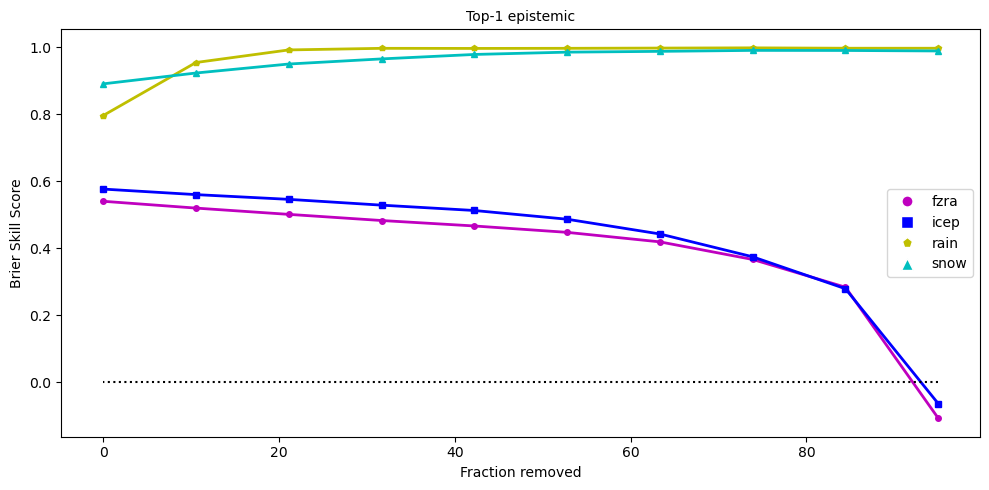

In [45]:
classifier_discard_fraction(
    test_data,
    #save_location=save_location,
    plt_title="Top-1 epistemic",
    prob_col="epistemic",
    prefix=None, 
    num_bins = 10,
    ascending = True,
    legend_cols = label_encoder.inverse_transform([0,1,2,3])
) 

## Skill-Score with Uncertainties

In [46]:
from matplotlib.colors import LogNorm

def classifier_skill_scores(
    true_labels,
    pred_probs,
    aleatoric,
    epistemic,
    total,
    evidential,
    num_bins=10,
    legend_cols=[r"Aleatoric $\sigma$", "Epistemic $\sigma$", "Total $\sigma$", "Entropy"]
):
    fig, axs = plt.subplots(1, 4, figsize=(10, 4.5), sharey="row")#, sharex="col")
    for k, uq in enumerate([aleatoric, epistemic, total, evidential]):
        
        bin_centers, results = sort_arr(
            true_labels, pred_probs, uq, num_bins * num_bins
        )
        norm = LogNorm(vmin=min(results["count"]) + 1, vmax=153027.0)
        rescaled_bin_centers = (bin_centers - np.min(bin_centers)) / np.ptp(bin_centers)
        
        
        if k == 3:
            ranger = ((0, 1), (0, 1))
        else:
            ranger = ((0, 0.25), (0, 0.25))
        
        # Plot the histogram
        _, _, _, sc = axs[k].hist2d(
            results["conf"],
            [np.sqrt(x) for x in results["bss"]], # this is the brier score not skill score
            weights=results["count"],
            bins=(num_bins, num_bins),
            range=((0, 1), (0, 1)),
            cmap="viridis_r",
            norm=norm,
        )
        
        axs[k].plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), "r:", lw=3)

        if k == 0:
            axs[k].set_ylabel("Brier Score", fontsize=10)
            axs[k].set_xlabel(f'{legend_cols[k]}', fontsize=10)
        elif k == 3:
            axs[k].set_xlabel("Entropy, $H$", fontsize=10)
        else:
            axs[k].set_xlabel(f'{legend_cols[k]}', fontsize=10)
            
        if k != 3:
            axs[k].set_xlim([0, 0.25])

        axs[k].set_ylim([0.0, 0.65])

    # Create a single colorbar
    cbaxes = fig.add_axes([0.125, -0.02, 0.8, 0.03])  # left, bottom, width, height]
    cbar = fig.colorbar(sc, cax=cbaxes, orientation="horizontal", pad=0.2, norm=norm)
    cbar.set_label("Count")
    plt.tight_layout()

/glade/derecho/scratch/schreck/tmp/ipykernel_47638/3072600283.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


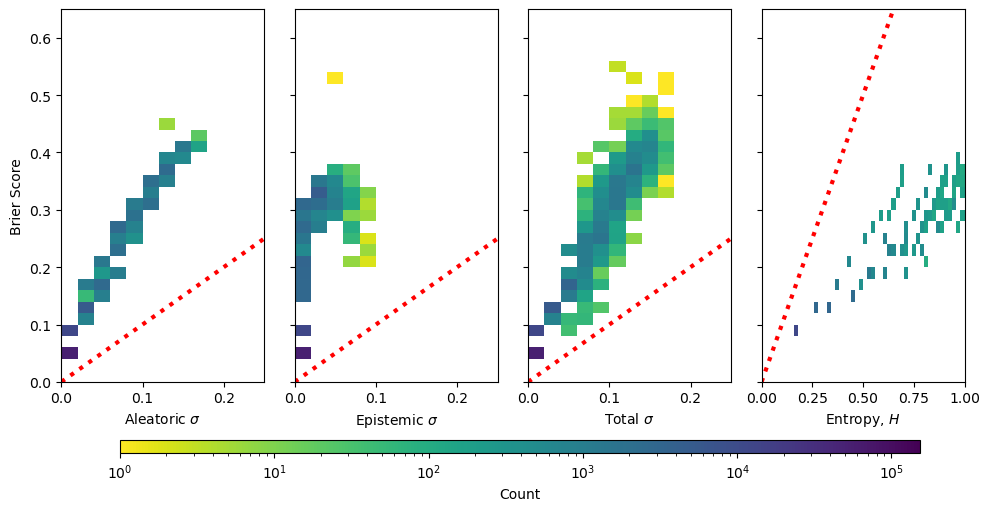

In [47]:
classifier_skill_scores(
    test_data["true_label"].values,
    pred_probs,
    test_data["aleatoric"].values,
    test_data["epistemic"].values,
    test_data["total"].values,
    test_data["entropy"].values,
    num_bins=50
)

In regression problems one expects monotonic (stronger: 1-1) between RMSE and predicted sigma. Are there such relationships between uncertainty and class probabilities? When using Brier, should we expect the relationship to be sigmoidal?

# Thanks for your time! Please contact MILES members for further assistance! 